# Geospatial Machine Learning: Classifying Land Use Based on Environmental and Economic Features

# 1. Introduction

In this project, we analyze the Geospatial Environmental and Socioeconomic Data to explore the relationship between tree cover loss by dominant driver, land cover, and Gross Domestic Product (GDP) across different Philippine regions. Our goal is to extract insights by examining how economic activity and land use patterns relate to deforestation and environmental change. By integrating spatial layers such as land cover classification, tree cover loss drivers, and gridded GDP data, we aim to identify regional trends and potential correlations that reveal the socioeconomic and environmental dynamics influencing forest degradation.

Specifically, we seek to answer the question:
How does tree cover loss by its dominant drivers correlate with land cover types and regional economic activity (GDP), and what patterns emerge across Luzon, Visayas, and Mindanao?

# 2. Description of the Dataset

## Geospatial Environmental and Socioeconomic Data  
**by Cathetorres (2020) – Kaggle**

This dataset is a comprehensive compilation of global **geospatial vector and raster data**, integrating diverse environmental and socioeconomic indicators. Collected from multiple authoritative sources, it provides detailed spatial layers useful for analysis in sustainability, development, and environmental monitoring.

The dataset is structured into **12 thematic folders**, each covering a distinct data category:

1. **Cities and Towns** – Geospatial data for urban areas in point and polygon formats.  
2. **Roads and Railroads** – Global transportation infrastructure networks.  
3. **Airports and Ports** – Locations of major air and sea transportation hubs.  
4. **Power Plants** – Spatial distribution of energy production facilities.  
5. **Gridded Population (2015)** – High-resolution (250 m) global population estimates.  
6. **Gridded GDP and HDI (1990–2015)** – Socioeconomic data showing economic productivity and development trends over time.  
7. **Land Cover (2015)** – Classification of global land cover types based on satellite data.  
8. **Tree Cover Loss by Dominant Driver** – Causes of deforestation disaggregated by primary driving factors.  
9. **Carbon Accumulation Potential** – Estimates of carbon sequestration from natural forest regrowth in forests and savannas.  
10. **Solar Energy Potential** – Spatial potential for solar power generation across the globe.  
11. **Air Temperature** – Global surface temperature data for climate studies.  
12. **Global Cattle Distribution (2010)** – Spatial density of cattle populations with 5-arcminute resolution.

## Dataset Folders Used

For this project, we utilize selected folders from the **Geospatial Environmental and Socioeconomic Data** collection to analyze the relationship between **tree cover loss**, **land cover**, and **economic activity (GDP)** in the Philippines. Our analysis focuses on understanding how different land use patterns and levels of economic development may be associated with forest degradation and environmental change.

### Land Cover

- **7. Gridded Land Cover 2015**  
  This dataset provides a global classification of land cover types at a 250 m resolution. It includes categories such as forest, cropland, urban area, grassland, and water. We use this as a base layer to contextualize areas of tree cover loss and to examine how land cover varies across economic regions.

### Tree Cover Loss

- **8. Tree Cover Loss by Dominant Driver (2001–2019)**  
  This dataset identifies the **main driver of tree cover loss** in each 10 km grid cell, classified into categories such as commodity-driven deforestation, shifting agriculture, forestry, wildfire, and urbanization. It allows us to assess how and why forest loss occurs in different parts of the country.

### Economic Activity

- **6. Gridded Gross Domestic Product and Human Development Index (1990–2015)**  
  This dataset provides **total GDP (PPP)** values at a 5 arc-minute (~10 km) resolution, enabling us to estimate economic activity at subnational scales. We use the 2015 GDP layer to explore potential spatial correlations between economic development and tree cover loss patterns.


# 3. Importing Files and Python Libraries

Here are the libraries and modules that will be used in this notebook:

In [43]:
import rasterio
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4
from scipy.stats import pearsonr

from rasterio.enums import Resampling
from rasterio.warp import reproject

### Importing the Files

Loads three geospatial datasets: tree cover loss, land cover, and GDP

In [2]:
tl_path = 'Goode_FinalClassification_19_05pcnt_prj.tif'
lc_path = 'ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7.tif'
gdp_path = 'GDP_PPP_1990_2015_5arcmin_v2.nc'

**Load Tree Cover Loss by Dominant Driver and Load Land Cover**

Loads tree cover loss and land cover rasters and extracts their metadata for further processing.

In [3]:
with rasterio.open(tl_path) as tree_src:
    tree_data = tree_src.read(1)
    tree_transform = tree_src.transform
    tree_crs = tree_src.crs
    tree_nodata = tree_src.nodata
    tree_meta = {
        'crs': tree_crs,
        'transform': tree_transform
    }
    print(f"Tree Cover Loss Raster: {tree_data.shape}, CRS: {tree_crs}")

with rasterio.open(lc_path) as lc_src:
    lc_data = lc_src.read(1)
    lc_transform = lc_src.transform
    lc_crs = lc_src.crs
    lc_nodata = lc_src.nodata
    lc_meta = {
        'crs': lc_crs,
        'transform': lc_transform
    }
    print(f"Land Cover Raster: {lc_data.shape}, CRS: {lc_crs}")

Tree Cover Loss Raster: (1864, 3737), CRS: EPSG:4326
Land Cover Raster: (64800, 129600), CRS: EPSG:4326


**Load GDP**

Loads and extracts 2015 GDP data from the NetCDF file using xarray.

In [4]:
ds = xr.open_dataset(gdp_path)
print(ds)

# Extract 2015 GDP layer
gdp_2015 = ds['GDP_PPP'].sel(time=2015)
print(f"GDP 2015 shape: {gdp_2015.shape}")

<xarray.Dataset>
Dimensions:    (longitude: 4320, latitude: 2160, time: 26)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
  * latitude   (latitude) float32 89.96 89.88 89.79 ... -89.79 -89.88 -89.96
  * time       (time) float32 1.99e+03 1.991e+03 ... 2.014e+03 2.015e+03
Data variables:
    GDP_PPP    (time, latitude, longitude) float32 ...
Attributes:
    creation_date:     02-Aug-2017 14:30:34
    resolution:        5 arc-min
    projection:        WGS84
    extent:            lat: 90�S - 90�N; lon: 180�E - 180�W
    product:           Total Gross Domestic Production (GDP) (PPP) for years ...
    citation:          When using the data, please refer to following publica...
    more information:  For more information, see: TBA
GDP 2015 shape: (2160, 4320)


# 4. Data Preprocessing and Cleaning

Before conducting analysis, the geospatial datasets require preprocessing to ensure they are properly aligned and comparable. We reproject and resample the datasets. Additionally, we address missing or invalid data by filtering out NoData values and outliers.

**Checking the Resolution**

In [5]:
print(f"Tree Loss CRS: {tree_crs}, Res: {tree_transform[0]}°")
print(f"Land Cover CRS: {lc_crs}, Res: {lc_transform[0]}°")
print(f"GDP CRS: EPSG:4326 (assumed), Res: ~5 arcmin (~10 km)")

Tree Loss CRS: EPSG:4326, Res: 0.09634259943603331°
Land Cover CRS: EPSG:4326, Res: 0.002777777777778°
GDP CRS: EPSG:4326 (assumed), Res: ~5 arcmin (~10 km)


**Resampling**

Since the shape of the datasets are not alligned we will define the spatial transform and shape of the 2015 GDP grid for alignment with other datasets.

In [6]:
gdp_lon = gdp_2015['longitude'].values
gdp_lat = gdp_2015['latitude'].values

from rasterio.transform import from_origin
gdp_transform = from_origin(
    west=gdp_lon.min(),
    north=gdp_lat.max(),
    xsize=abs(gdp_lon[1] - gdp_lon[0]),
    ysize=abs(gdp_lat[1] - gdp_lat[0])
)

gdp_shape = gdp_2015.shape

Reprojects a source raster array to match a target shape, transform, and CRS.

In [7]:
def reproject_match(src_array, src_meta, dst_shape, dst_transform, dst_crs="EPSG:4326", method=Resampling.mode):
    dst_array = np.empty(dst_shape, dtype=src_array.dtype)
    reproject(
        source=src_array,
        destination=dst_array,
        src_transform=src_meta['transform'],
        src_crs=src_meta['crs'],
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=method
    )
    return dst_array

In [8]:
tree_data_resampled = reproject_match(
    src_array=tree_data,
    src_meta=tree_meta,
    dst_shape=gdp_shape,
    dst_transform=gdp_transform,
    method=Resampling.nearest
)

lc_data_resampled = reproject_match(
    src_array=lc_data,
    src_meta=lc_meta,
    dst_shape=gdp_shape,
    dst_transform=gdp_transform,
    method=Resampling.mode
)

**Mask Invalid Values and Create DataFrame**

Filters valid pixels and creates a DataFrame combining GDP, tree loss driver, and land cover values.

In [9]:
gdp_array = gdp_2015.values

valid_mask = (
    (gdp_array >= 0) &
    (tree_data_resampled >= 0) & (tree_data_resampled <= 5) &
    (lc_data_resampled >= 0)
)

df = pd.DataFrame({
    "GDP": gdp_array[valid_mask],
    "TreeLossDriver": tree_data_resampled[valid_mask].astype(int),
    "LandCover": lc_data_resampled[valid_mask].astype(int)
})

In [10]:
print(df.head())

   GDP  TreeLossDriver  LandCover
0  0.0               0        200
1  0.0               0        200
2  0.0               0        200
3  0.0               0        200
4  0.0               0        200


**Creating a Dataframe**

Creates 2D latitude and longitude grids matching the GDP data shape using meshgrid.

In [11]:
lon_vals = gdp_2015['longitude'].values
lat_vals = gdp_2015['latitude'].values
lon_grid, lat_grid = np.meshgrid(lon_vals, lat_vals)

Creates a DataFrame with GDP, tree loss driver, land cover, and coordinates for valid pixels.

In [12]:
df = pd.DataFrame({
    "GDP": gdp_array[valid_mask],
    "TreeLossDriver": tree_data_resampled[valid_mask].astype(int),
    "LandCover": lc_data_resampled[valid_mask].astype(int),
    "Lat": lat_grid[valid_mask],
    "Lon": lon_grid[valid_mask]
})

**Filtering**

Since our target location is only Philippines and its 3 main islands groups, we will filter the data based on the coordinates and store them in their own dataframes for easier access.

In [13]:
philippines_df = df[
    (df["Lat"] >= 4.5) & (df["Lat"] <= 21) &
    (df["Lon"] >= 116) & (df["Lon"] <= 127)
]

In [14]:
luzon_df = philippines_df[
    (philippines_df["Lat"] >= 12.0) & (philippines_df["Lat"] <= 21.0) &
    (philippines_df["Lon"] >= 118.0) & (philippines_df["Lon"] <= 124.0)
]

visayas_df = philippines_df[
    (philippines_df["Lat"] >= 9.5) & (philippines_df["Lat"] < 12.0) &
    (philippines_df["Lon"] >= 122.0) & (philippines_df["Lon"] <= 126.0)
]

mindanao_df = philippines_df[
    (philippines_df["Lat"] >= 4.5) & (philippines_df["Lat"] < 9.5) &
    (philippines_df["Lon"] >= 124.0) & (philippines_df["Lon"] <= 127.0)
]

# 5. Exploratory Data Analysis

In this section, we perform an exploratory analysis of the geospatial datasets,tree cover loss drivers, land cover, and Gross Domestic Product (GDP), to understand their spatial patterns and relationships across the Philippines. We focus on the three main island groups: Luzon, Visayas, and Mindanao, by filtering the data using approximate latitude and longitude boundaries.

It is important to note that these geographic filters define rectangular bounding boxes which approximate the locations of the Philippines and its island groups. Therefore, the resulting analyses are estimates, as this method does not account for the exact shapes or coastlines of the islands.

## 1. What is the distribution of Tree Cover Loss by Dominant Drivers in Philippines?

### Distribution of Tree Cover Loss by Dominant Drivers in the Philippines

| Code | Driver Description                                                                 | Count |
|------|-----------------------------------------------------------------------------------|-------|
| 0    | None                                                                              | 1256  |
| 1    | Commodity-driven deforestation: long-term, permanent conversion of forest and shrubland to a non-forest land use such as agriculture (including oil palm), mining, or energy infrastructure | 1153  |
| 2    | Shifting agriculture: small to medium-scale forest and shrubland conversion for agriculture that is later abandoned and followed by subsequent forest regrowth | 2178  |
| 3    | Forestry: large-scale forestry operations occurring within managed forests and tree plantations | 479   |
| 4    | Wildfire: large-scale forest loss resulting from the burning of forest vegetation with no visible human conversion or agricultural activity afterward | 0     |
| 5    | Urbanization: forest and shrubland conversion for the expansion and intensification of existing urban centers | 195   |

**Interpretation:**  
- The leading cause of tree cover loss in the Philippines is **shifting agriculture (code 2)**, with 2178 pixels.
- **None (code 0)** and **commodity-driven deforestation (code 1)** are also significant contributors.
- **Forestry (code 3)** and **urbanization (code 5)** play smaller roles.
- **Wildfire (code 4)** does not appear as a significant driver in this dataset.

Most tree cover loss is due to shifting agriculture, followed by commodity-driven deforestation and areas with no dominant driver. Forestry and urbanization contribute less, and wildfire is not a notable factor in this dataset.

Tree Cover Loss Drivers in Philippines:
TreeLossDriver
0    1256
1    1153
2    2178
3     479
5     195
Name: count, dtype: int64 



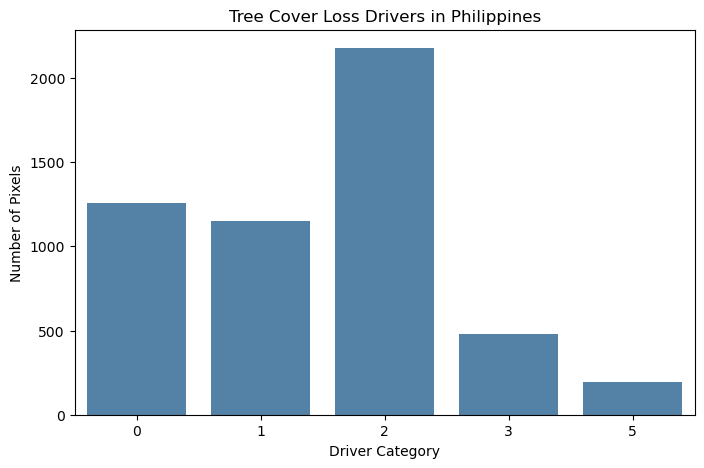

In [15]:
# Function to plot bar charts for a region with fixed color
def plot_driver_distribution(counts, region_name):
    plt.figure(figsize=(8,5))
    sns.barplot(x=counts.index.astype(str), y=counts.values, color='steelblue')
    plt.title(f'Tree Cover Loss Drivers in {region_name}')
    plt.xlabel('Driver Category')
    plt.ylabel('Number of Pixels')
    plt.xticks(rotation=0)
    plt.show()

# Calculate counts for Philippines and regions
philippines_counts = philippines_df['TreeLossDriver'].value_counts().sort_index()
luzon_counts = luzon_df['TreeLossDriver'].value_counts().sort_index()
visayas_counts = visayas_df['TreeLossDriver'].value_counts().sort_index()
mindanao_counts = mindanao_df['TreeLossDriver'].value_counts().sort_index()

# Print counts
print("Tree Cover Loss Drivers in Philippines:")
print(philippines_counts, "\n")

# Plot bar charts
plot_driver_distribution(philippines_counts, 'Philippines')


## 2. What is the distribution of Tree Cover Loss by Dominant Drivers in the 3 main island groups?

### Distribution of Tree Cover Loss by Dominant Drivers in Luzon, Visayas, and Mindanao

| Region   | None (0) | Commodity-driven (1) | Shifting Agriculture (2) | Forestry (3) | Wildfire (4) | Urbanization (5) |
|----------|----------|----------------------|--------------------------|--------------|--------------|------------------|
| **Luzon**    | 549      | 134                  | 892                      | 147          | 0            | 98               |
| **Visayas**  | 247      | 20                   | 361                      | 104          | 0            | 42               |
| **Mindanao** | 111      | 197                  | 476                      | 168          | 0            | 38               |

**Interpretation:**
- **Shifting agriculture (2)** is the leading cause of tree cover loss in all three regions, especially in Luzon and Mindanao.
- **Commodity-driven deforestation (1)** is most prominent in Mindanao (197 pixels), but much lower in Luzon and Visayas.
- **Forestry (3)** is a notable driver in all regions, with the highest count in Mindanao.
- **Urbanization (5)** contributes more in Luzon than in Visayas or Mindanao.
- **None (0)** is also a significant category, especially in Luzon.
- **Wildfire (4)** does not appear as a significant driver in any region.

Overall, the dominant drivers of tree cover loss vary by region, with shifting agriculture being the most consistent and commodity-driven deforestation particularly important in Mindanao.

In [16]:
# Print counts
print("Tree Cover Loss Drivers in Luzon:")
print(luzon_counts, "\n")

print("Tree Cover Loss Drivers in Visayas:")
print(visayas_counts, "\n")

print("Tree Cover Loss Drivers in Mindanao:")
print(mindanao_counts, "\n")

Tree Cover Loss Drivers in Luzon:
TreeLossDriver
0    549
1    134
2    892
3    147
5     98
Name: count, dtype: int64 

Tree Cover Loss Drivers in Visayas:
TreeLossDriver
0    247
1     20
2    361
3    104
5     42
Name: count, dtype: int64 

Tree Cover Loss Drivers in Mindanao:
TreeLossDriver
0    111
1    197
2    476
3    168
5     38
Name: count, dtype: int64 



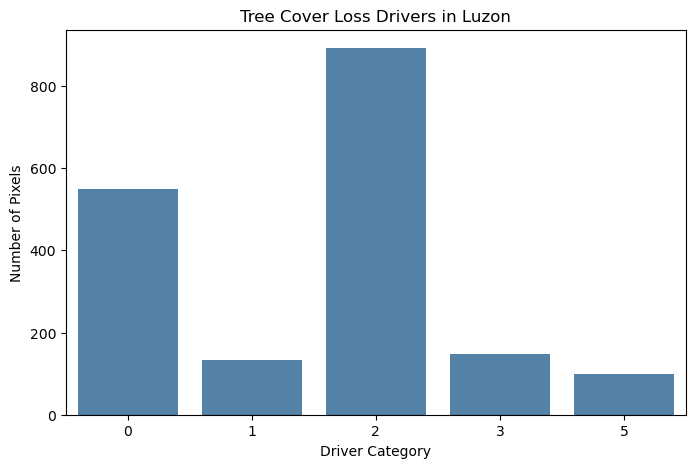

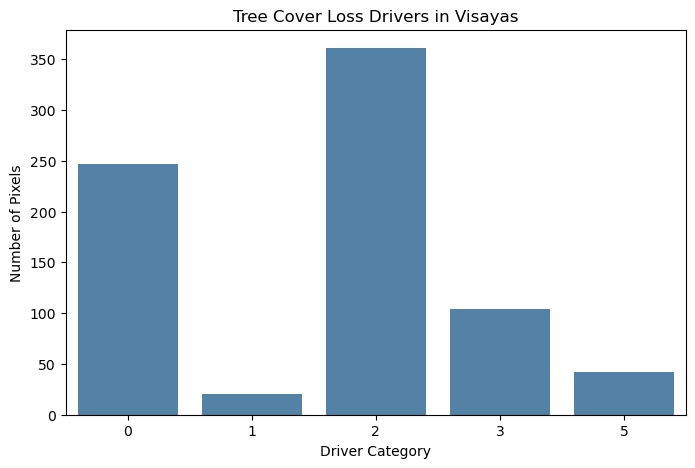

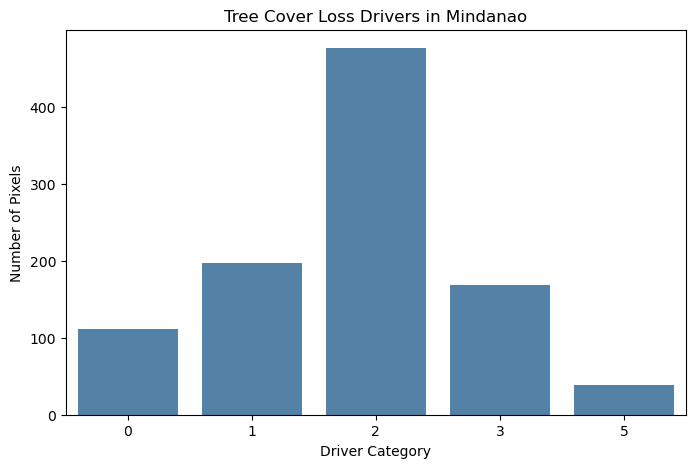

In [17]:
# Plot bar charts
plot_driver_distribution(luzon_counts, 'Luzon')
plot_driver_distribution(visayas_counts, 'Visayas')
plot_driver_distribution(mindanao_counts, 'Mindanao')

## 3. What is the GDP distribution in the Philippines and each island group?

In [18]:
def plot_gdp_distribution(df, region_name):
    plt.figure(figsize=(8,5))
    sns.histplot(df['GDP'], bins=30, color='gold', kde=True)
    plt.title(f'GDP Distribution in {region_name}')
    plt.xlabel('GDP (PPP)')
    plt.ylabel('Number of Pixels')
    plt.show()

In [19]:
# Print GDP statistics for each region
print("GDP Statistics in Philippines:")
print(philippines_df['GDP'].describe(), "\n")

print("GDP Statistics in Luzon:")
print(luzon_df['GDP'].describe(), "\n")

print("GDP Statistics in Visayas:")
print(visayas_df['GDP'].describe(), "\n")

print("GDP Statistics in Mindanao:")
print(mindanao_df['GDP'].describe(), "\n")

GDP Statistics in Philippines:
count    5.261000e+03
mean     1.377989e+08
std      1.397826e+09
min      0.000000e+00
25%      6.008857e+06
50%      2.498227e+07
75%      8.361836e+07
max      6.778830e+10
Name: GDP, dtype: float64 

GDP Statistics in Luzon:
count    1.820000e+03
mean     2.707654e+08
std      2.355523e+09
min      0.000000e+00
25%      6.229285e+06
50%      3.136837e+07
75%      1.225294e+08
max      6.778830e+10
Name: GDP, dtype: float64 

GDP Statistics in Visayas:
count    7.740000e+02
mean     1.250663e+08
std      3.085126e+08
min      0.000000e+00
25%      2.268024e+07
50%      6.858916e+07
75%      1.414241e+08
max      4.904178e+09
Name: GDP, dtype: float64 

GDP Statistics in Mindanao:
count    9.900000e+02
mean     5.847284e+07
std      1.044687e+08
min      0.000000e+00
25%      7.822219e+06
50%      2.565220e+07
75%      6.791322e+07
max      1.364762e+09
Name: GDP, dtype: float64 



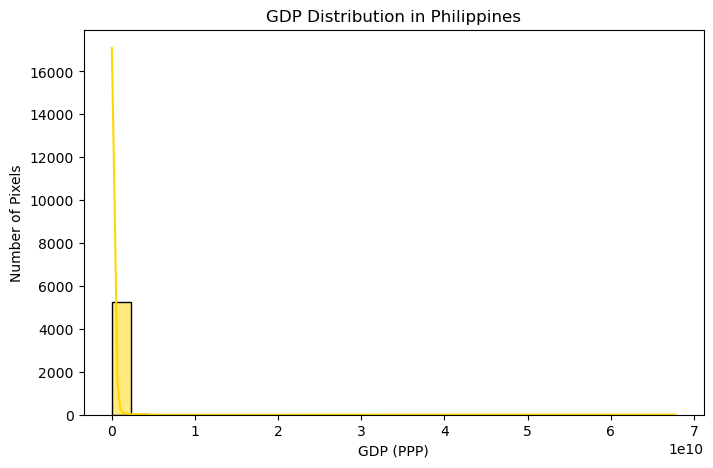

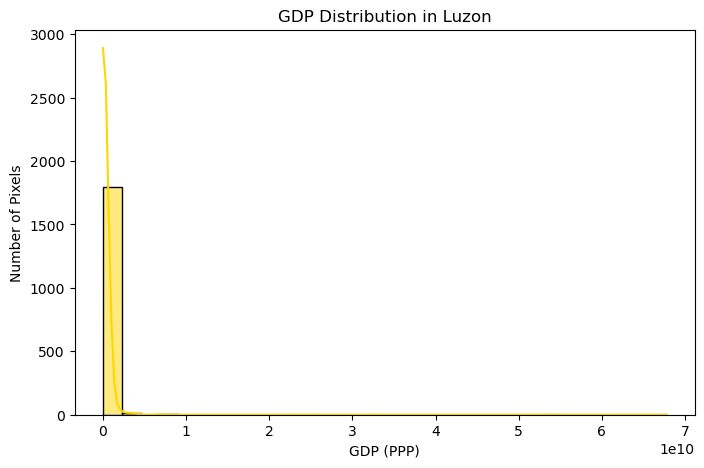

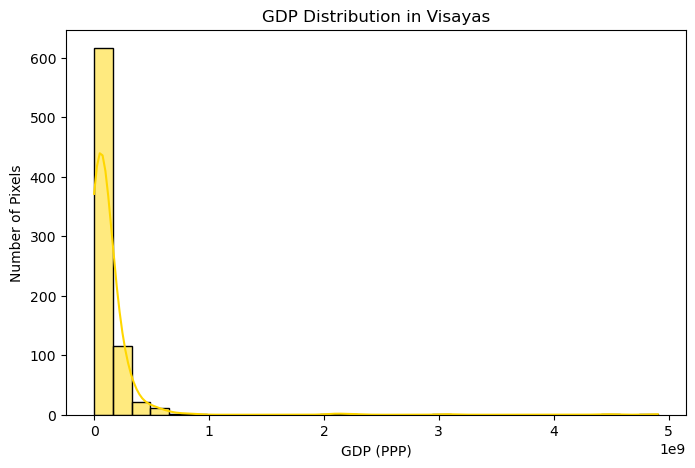

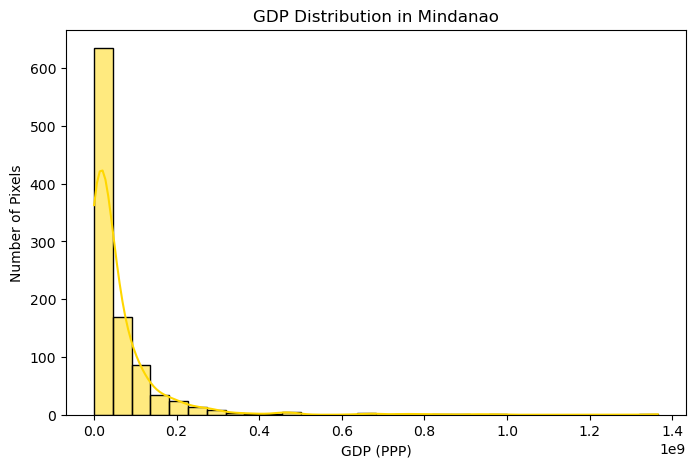

In [20]:
plot_gdp_distribution(philippines_df, 'Philippines')
plot_gdp_distribution(luzon_df, 'Luzon')
plot_gdp_distribution(visayas_df, 'Visayas')
plot_gdp_distribution(mindanao_df, 'Mindanao')

### Interpretation:

Philippines GDP Distribution - The distribution is highly skewed to the right, indicating that a majority of the observations, in this case, the different areas, have low contribution to the total GDP of the country. However, there are some outliers that have a large contribution to the GDP of the country, which can be the the urban areas. 

Luzon GDP Distribution - Similar to the previous distribution, the values are still highly right-skewed, which can show the difference between the rural and urban areas. Additionally, the Luzon GDP distribution contains the maximum value for the GDP.

Visayas GDP Distribution - Although still right-skewed, the distribution of GDP in Visayas is more spread out compared to Luzon. This can indicate that there are multiple areas that contribute to the total GDP in Visayas.

Mindanao GDP Distribution - Also still right skewed, but more distributed as compared to Visayas. This shows that there are more areas that are able to contribute to the total GDP of Mindanao.

## 4. Is there a difference in land cover types across Luzon, Visayas, and Mindanao?

In [21]:
lc_luzon = luzon_df['LandCover'].value_counts().sort_index()
lc_visayas = visayas_df['LandCover'].value_counts().sort_index()
lc_mindanao = mindanao_df['LandCover'].value_counts().sort_index()

In [22]:
# Print Land Cover counts for each region (for number 5)
print("Land Cover Types in Luzon:")
print(lc_luzon, "\n")

print("Land Cover Types in Visayas:")
print(lc_visayas, "\n")

print("Land Cover Types in Mindanao:")
print(lc_mindanao, "\n")

Land Cover Types in Luzon:
LandCover
10      31
11     360
30     347
40      62
50     548
150      4
170      7
190     13
210    448
Name: count, dtype: int64 

Land Cover Types in Visayas:
LandCover
10      15
11     121
30     201
40      22
50     126
170      2
190      2
210    285
Name: count, dtype: int64 

Land Cover Types in Mindanao:
LandCover
10      56
11      32
30     299
40     119
50     341
170      1
190      1
210    141
Name: count, dtype: int64 



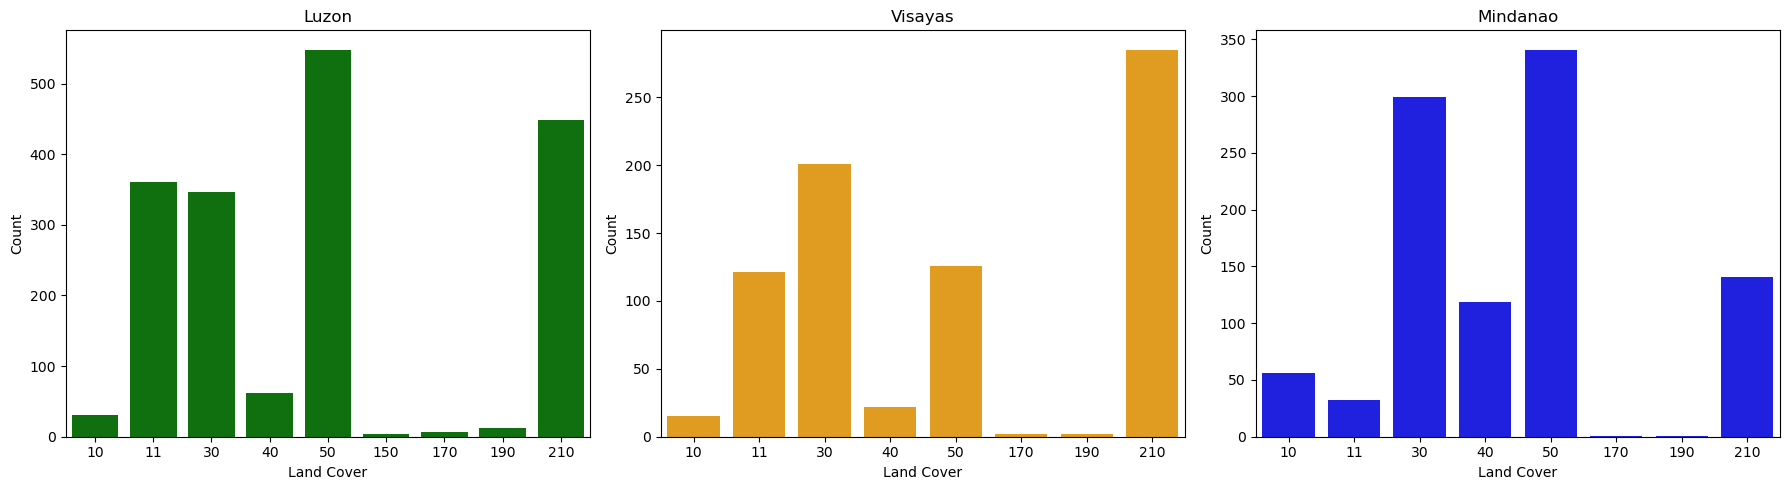

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.barplot(x=lc_luzon.index, y=lc_luzon.values, ax=axes[0], color='green')
axes[0].set_title("Luzon")
sns.barplot(x=lc_visayas.index, y=lc_visayas.values, ax=axes[1], color='orange')
axes[1].set_title("Visayas")
sns.barplot(x=lc_mindanao.index, y=lc_mindanao.values, ax=axes[2], color='blue')
axes[2].set_title("Mindanao")
for ax in axes: ax.set_xlabel("Land Cover"), ax.set_ylabel("Count")
plt.tight_layout()
plt.show()


### Interpretation

Luzon
Based on the legend for the land cover data, Luzon is predominantly covered by tree cover, which constitutes the highest pixel count. Water is the second most abundant land cover type. The relatively high water pixel count is largely due to water pixels in the grid cells surrounding the main islands of the Philippines.

Visayas
In contrast, the Visayas region is mainly covered by water, reflecting its geographical nature as an archipelago composed of numerous small islands separated by seas. This characteristic results in water being the dominant land cover class in this region.

Mindanao
Mindanao is primarily covered by tree cover and mosaic cropland/natural vegetation. Among the three regions, Mindanao has the least water coverage, which aligns with its larger contiguous landmass compared to the island groups in the Visayas. 

Overall, Luzon is characterized by a dominant tree cover, while Visayas is primarily an archipelagic region, having a large amount of water cover. On the other hand, Mindanao is also mainly covered by trees, mosaic cropland, and natural vegetation.

### Interpretation 

GDP and Tree Loss Driver has a near-zero correlation value of -0.0057. This indicates no meaningful linear relationship between GDP and the primary drivers of tree loss in Luzon. Economic activity as measured by GDP does not seem directly linked to these different drivers.

GDP and Land Cover has a very small positive correlation value of 0.063. This can suggests a very slight positive relationship, but it is too small of a number to be able to conclude from. This correlation value implies that changes in GDP are not strongly associated with changes in land cover classes.

Tree Loss drivers and Land cover has a very small negative correlation value. This value can suggest that as the intensity or presence of tree loss drivers increases, certain land cover classes (which could mainly mean tree covered areas) decrease. In a way, this can be made sense from, however, the correlation is still quite small.

## 5. Is there spatial clustering of low-GDP areas in Mindanao?

In [24]:
low_gdp_threshold = mindanao_df["GDP"].quantile(0.25)
low_gdp_mindanao = mindanao_df[mindanao_df["GDP"] <= low_gdp_threshold]

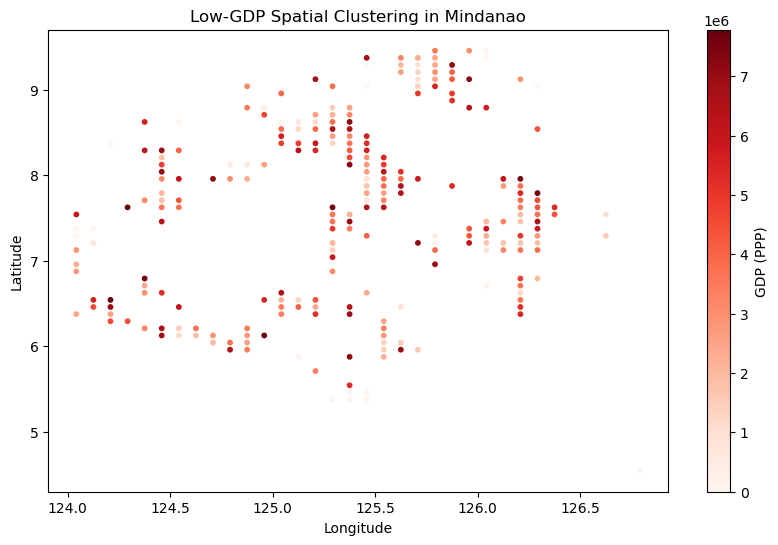

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(low_gdp_mindanao["Lon"], low_gdp_mindanao["Lat"], c=low_gdp_mindanao["GDP"], cmap="Reds", s=10)
plt.colorbar(label="GDP (PPP)")
plt.title("Low-GDP Spatial Clustering in Mindanao")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


### Interpretation

The plot shows the distribution of GDP across Mindanao, where darker colored points represent higher GDP values. These darker areas are relatively few, indicating that regions with higher economic activity are limited. Overall, the visualization highlights that much of Mindanao has low GDP levels. This uneven distribution can  be influenced by various factors, including geographical differences, infrastructure differences, and the region’s mostly agricultural landscape.



## 6. Is there spatial clustering of low-GDP areas in Visayas?

In [26]:
low_gdp_threshold = visayas_df["GDP"].quantile(0.25)
low_gdp_visayas = visayas_df[visayas_df["GDP"] <= low_gdp_threshold]

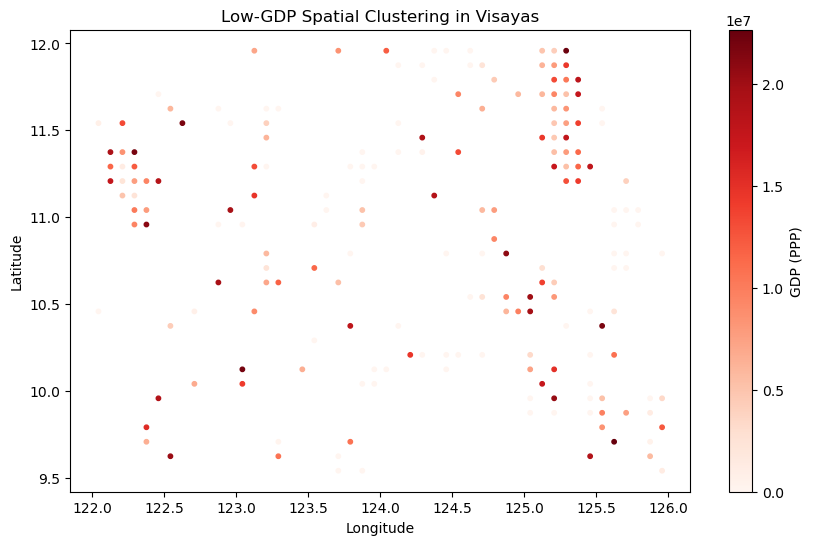

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(low_gdp_visayas["Lon"], low_gdp_visayas["Lat"], c=low_gdp_visayas["GDP"], cmap="Reds", s=10)
plt.colorbar(label="GDP (PPP)")
plt.title("Low-GDP Spatial Clustering in Visayas")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


### Interpretation

The plot illustrates the spatial distribution of GDP in the Visayas region. The majority of the data points are lightly colored, indicating low GDP values across most of the area. However, there are a few notable clusters of darker red points, suggesting localized regions with moderately higher economic activity. These clusters are not widespread, implying that high-GDP zones are limited and concentrated, possibly around urban centers or regional economic hubs. The general pattern highlights that the Visayas, like Mindanao, experiences predominantly low GDP levels, potentially due to similar structural factors such as limited industrial presence, geographic fragmentation among islands, and reliance on agriculture or low-output economic sectors.giv

## 7. Is there spatial clustering of low-GDP areas in Luzon?

In [28]:
low_gdp_threshold = luzon_df["GDP"].quantile(0.25)
low_gdp_luzon = luzon_df[luzon_df["GDP"] <= low_gdp_threshold]

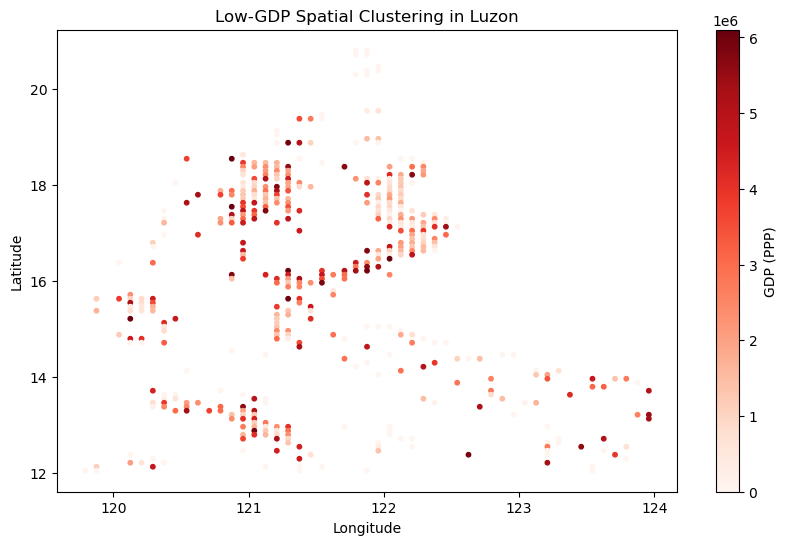

In [29]:
plt.figure(figsize=(10, 6))
plt.scatter(low_gdp_luzon["Lon"], low_gdp_luzon["Lat"], c=low_gdp_luzon["GDP"], cmap="Reds", s=10)
plt.colorbar(label="GDP (PPP)")
plt.title("Low-GDP Spatial Clustering in Luzon")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### Interpretation

The visualization shows the spatial distribution of GDP across Luzon. Compared to Visayas and Mindanao, Luzon exhibits a denser and more widespread clustering of higher GDP values, as indicated by the larger concentration of darker red points. These clusters are particularly prominent around the central part of the island, which likely corresponds to economically developed areas such as Metro Manila and neighboring provinces. While lower-GDP zones still exist, especially in the peripheries and mountainous regions, the overall pattern reflects a more urbanized and industrialized economic landscape. This distribution suggests stronger infrastructure, higher population density, and more diversified economic activities concentrated in Luzon, making it the economic core of the Philippines.

## 8. What is the distribution of tree loss drivers across major land cover types (e.g., forest, cropland, urban)?

In [30]:
cross_tab = philippines_df.groupby(['LandCover', 'TreeLossDriver']).size().unstack(fill_value=0)

In [31]:
cross_tab_norm = cross_tab.div(cross_tab.sum(axis=1), axis=0)

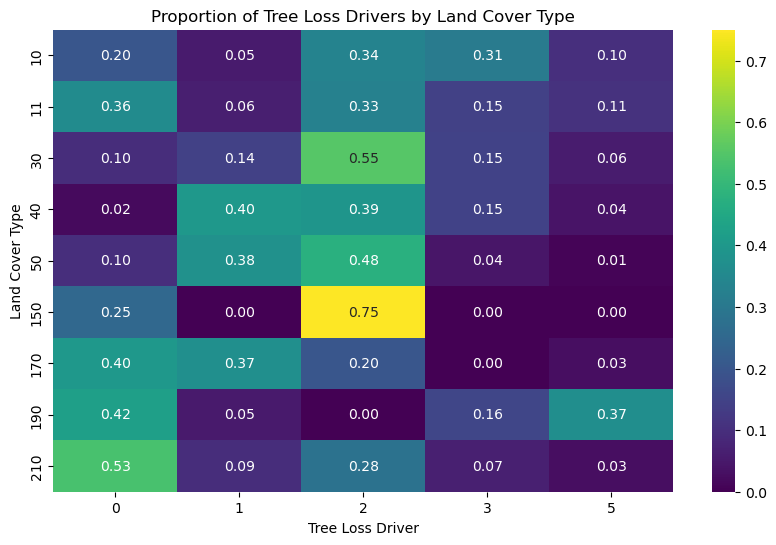

In [32]:
plt.figure(figsize=(10,6))
sns.heatmap(cross_tab_norm, cmap='viridis', annot=True, fmt=".2f")
plt.title('Proportion of Tree Loss Drivers by Land Cover Type')
plt.xlabel('Tree Loss Driver')
plt.ylabel('Land Cover Type')
plt.show()

### Interpretation

Using the dataset description, the tree loss drivers are respectively:
(1) Commodity-driven deforestation
(2) Shifting agriculture
(3) Forestry
(4) Wildfire
(5) Urbanization

The heatmap shows the distribution of tree loss drivers across the various land cover types in the Philippines. Most notably, Driver 2 is the most influential especially for sparse vegetation (150) and mosaic cropland (30) land covers. This could mean that shifting agriculture (driver 2) plays a big role in deforestation in these areas. 


## 9. What is the relationship between tree loss intensity and economic output in Luzon?

In [33]:
driver_gdp_luzon = luzon_df.groupby("TreeLossDriver")["GDP"].mean().sort_index()
driver_gdp_luzon

TreeLossDriver
0    5.391229e+08
1    3.808576e+07
2    6.526911e+07
3    1.664572e+08
5    1.112467e+09
Name: GDP, dtype: float32

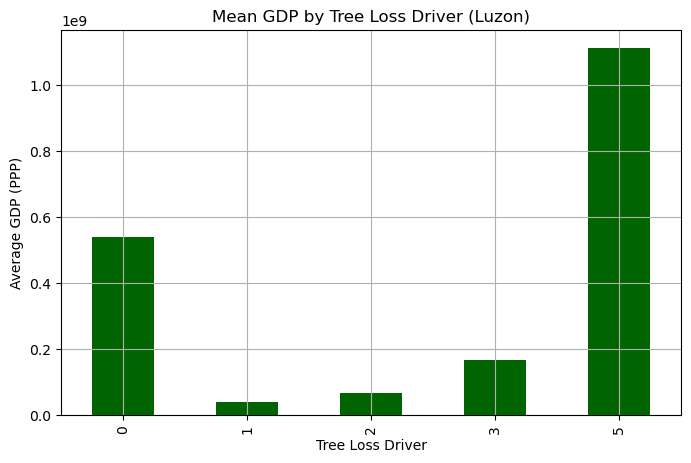

In [34]:
driver_gdp_luzon.plot(kind="bar", figsize=(8,5), color='darkgreen')
plt.title("Mean GDP by Tree Loss Driver (Luzon)")
plt.xlabel("Tree Loss Driver")
plt.ylabel("Average GDP (PPP)")
plt.grid(True)
plt.show()

### Interpretation

The chart shows the relationship between different tree loss drivers and the average GDP of areas in Luzon. It highlights that areas influenced by driver 5 (Urbanization) tend to have significantly higher GDP compared to areas affected by other drivers. This suggests that more urbanized regions experience tree loss due to economic expansion, which contributes to higher economic output. Other drivers have much lower average GDP levels, which can show the scale of these activities. These drivers and their GDP levels can show the type of tree loss driver are based on what economic action is taking place in a given area.

# 6. Correlation Analysis

## Correlation between GDP, Land Cover, and Tree Loss Driver in Philippines

In [35]:
corr_philippines = philippines_df[["GDP", "TreeLossDriver", "LandCover"]].corr()
corr_philippines

,GDP,TreeLossDriver,LandCover
GDP,1.000000,0.007995,0.033843
TreeLossDriver,0.007995,1.000000,-0.279560
LandCover,0.033843,-0.279560,1.000000


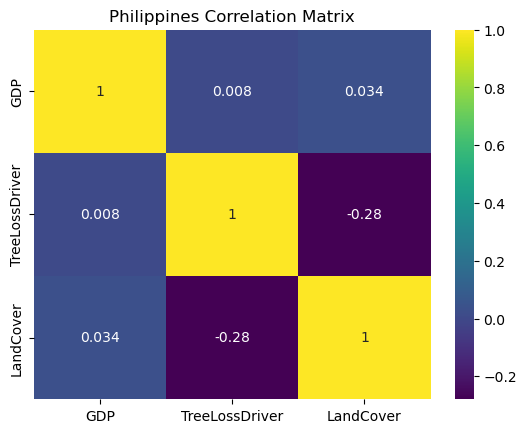

In [36]:
sns.heatmap(corr_philippines, annot=True, cmap="viridis")
plt.title("Philippines Correlation Matrix")
plt.show()

### Correlation Analysis – Philippines Overview

The correlation values suggest the following:

- **GDP and TreeLossDriver (correlation = 0.008)**:  
  There is virtually no correlation between GDP and the dominant drivers of tree cover loss. This means that whether an area has high or low economic activity does not strongly relate to the type of deforestation occurring there.

- **GDP and LandCover (correlation = 0.034)**:  
  There is a very weak positive correlation between GDP and land cover types. This indicates a slight tendency for some land cover categories to be associated with higher economic activity, but the relationship is too weak to be considered meaningful.

- **TreeLossDriver and LandCover (correlation = -0.280)**:  
  This moderate negative correlation suggests that certain land cover types are more or less prone to specific deforestation drivers. For example, forested areas may be more likely affected by commodity-driven deforestation or logging, while other land types may correspond to different tree loss causes.

- GDP is largely independent of both land cover and deforestation drivers, indicating that economic output is not directly associated with how or why deforestation happens.
- The strongest relationship observed is between land cover and deforestation drivers, implying that the physical landscape significantly influences the type of environmental pressure it experiences. This insight is important for region-specific conservation planning.

## Correlation between GDP, Land Cover, and Tree Loss Driver in Luzon

In [37]:
corr_luzon = luzon_df[["GDP", "TreeLossDriver", "LandCover"]].corr()
corr_luzon

,GDP,TreeLossDriver,LandCover
GDP,1.000000,-0.005683,0.063359
TreeLossDriver,-0.005683,1.000000,-0.210901
LandCover,0.063359,-0.210901,1.000000


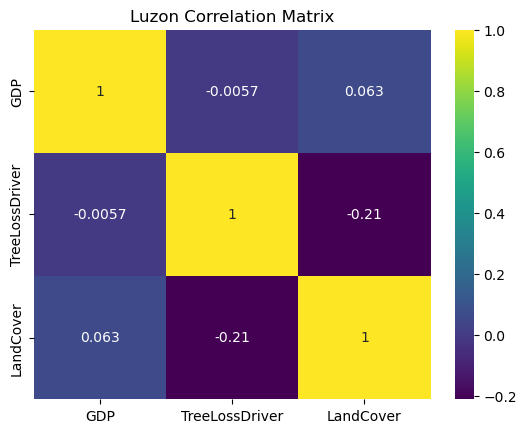

In [38]:
sns.heatmap(corr_luzon, annot=True, cmap="viridis")
plt.title("Luzon Correlation Matrix")
plt.show()

### Correlation Analysis – Luzon

The correlation values for Luzon suggest the following:

- **GDP and TreeLossDriver (correlation = -0.006)**:  
  There is essentially no correlation between GDP and the dominant drivers of tree cover loss in Luzon. Economic activity does not appear to influence or align with specific deforestation causes in this region.

- **GDP and LandCover (correlation = 0.063)**:  
  There is a very weak positive correlation between GDP and land cover types. This suggests a slight tendency for higher GDP values to be associated with certain land cover categories, possibly reflecting urban or developed land uses, but the relationship remains too weak to be conclusive.

- **TreeLossDriver and LandCover (correlation = -0.211)**:  
  A moderate negative correlation exists between tree loss drivers and land cover. This indicates that particular land cover types in Luzon are more likely to be associated with specific deforestation drivers. For example, forested areas may be more prone to agricultural expansion or logging, while other land types experience less pressure.

- As with the national trend, GDP in Luzon shows no significant relationship with deforestation patterns, implying that economic growth and tree cover loss are likely influenced by different processes or policy contexts.
- The moderate negative correlation between TreeLossDriver and LandCover highlights the importance of land use types in shaping deforestation risks. Conservation efforts should therefore consider the spatial distribution of land cover when addressing environmental impacts.

## Correlation between GDP, Land Cover, and Tree Loss Driver in Visayas

In [39]:
corr_visayas = visayas_df[["GDP", "TreeLossDriver", "LandCover"]].corr()
corr_visayas

,GDP,TreeLossDriver,LandCover
GDP,1.000000,0.025526,-0.037029
TreeLossDriver,0.025526,1.000000,-0.407617
LandCover,-0.037029,-0.407617,1.000000


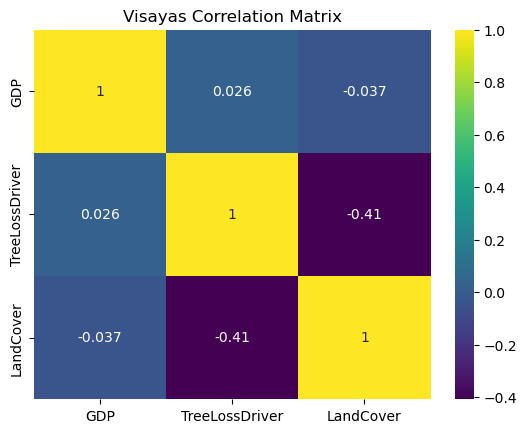

In [40]:
sns.heatmap(corr_visayas, annot=True, cmap="viridis")
plt.title("Visayas Correlation Matrix")
plt.show()

### Correlation Analysis – Visayas

The correlation values for Visayas indicate the following:

- **GDP and TreeLossDriver (correlation = 0.026)**:  
  There is a very weak positive correlation between GDP and the dominant drivers of tree cover loss. This suggests that regions with slightly higher economic activity may experience different deforestation drivers, but the relationship is too weak to draw strong conclusions.

- **GDP and LandCover (correlation = -0.037)**:  
  This very weak negative correlation implies that GDP values have almost no meaningful association with land cover types in Visayas. Economic activity is likely distributed across various land uses without a consistent pattern.

- **TreeLossDriver and LandCover (correlation = -0.408)**:  
  A moderately strong negative correlation exists between tree loss drivers and land cover. This suggests that certain land cover types are strongly associated with specific deforestation drivers. For example, forested areas may be more affected by shifting agriculture or commodity-driven activities, while developed areas may see less of these pressures.

- GDP has minimal correlation with both deforestation drivers and land cover, suggesting that economic activity is not a strong predictor of land use or environmental degradation in the region.
- The moderate-to-strong negative correlation between TreeLossDriver and LandCover underscores the role of land use type in shaping environmental outcomes. This relationship is stronger in Visayas than in Luzon or Mindanao, indicating a clearer link between what type of land exists and why trees are being lost.
- These insights support the need for land-type-specific interventions, especially in forested or agricultural areas where environmental pressure is highest.

## Correlation between GDP, Land Cover, and Tree Loss Driver in Mindanao

In [41]:
corr_mindanao = mindanao_df[["GDP", "TreeLossDriver", "LandCover"]].corr()
corr_mindanao

,GDP,TreeLossDriver,LandCover
GDP,1.000000,0.197956,-0.012100
TreeLossDriver,0.197956,1.000000,-0.329477
LandCover,-0.012100,-0.329477,1.000000


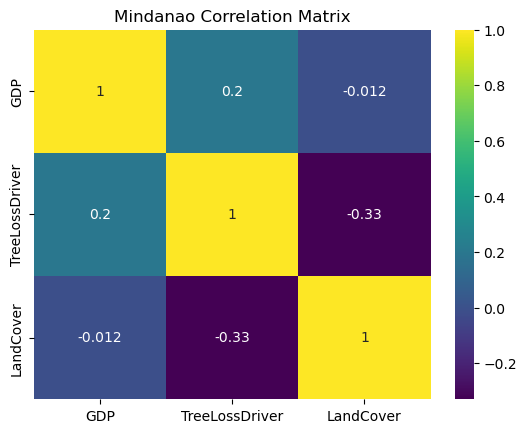

In [42]:
sns.heatmap(corr_mindanao, annot=True, cmap="viridis")
plt.title("Mindanao Correlation Matrix")
plt.show()

### Correlation Analysis – Mindanao

The correlation values for Mindanao suggest the following:

- **GDP and TreeLossDriver (correlation = 0.198)**:  
  This weak positive correlation indicates a slight tendency for areas with higher GDP to be associated with specific drivers of tree cover loss. It may suggest that as economic activity increases, certain types of deforestation (e.g., urbanization or commodity-driven) become more common, but the relationship remains modest.

- **GDP and LandCover (correlation = -0.012)**:  
  There is virtually no correlation between GDP and land cover types. This means that economic activity in Mindanao is not strongly linked to specific land use patterns, possibly due to the region's mix of agricultural, forest, and urban areas.

- **TreeLossDriver and LandCover (correlation = -0.329)**:  
  A moderate negative correlation exists between deforestation drivers and land cover types. This suggests that different land cover classes in Mindanao are associated with distinct deforestation pressures. For instance, forested land might be more affected by logging or agriculture, while non-forested areas see less tree loss.

- The slightly higher correlation between GDP and TreeLossDriver in Mindanao (compared to other regions) may reflect increasing environmental pressures in economically active zones.
- Land cover continues to be moderately associated with the types of deforestation observed, reinforcing the idea that physical landscape characteristics play a central role in environmental change.
- These results imply that sustainable development strategies in Mindanao should consider both economic growth and land use planning to mitigate unwanted deforestation.

# 7. Significance Testing

To assess whether the observed correlations reflect meaningful relationships rather than random associations, statistical significance testing was conducted for each pair of variables, GDP, tree loss drivers, and land cover, across Mindanao, Visayas, Luzon, and the entire Philippines. This step ensures that the analysis goes beyond correlation coefficients and identifies which patterns hold substantial evidence for interpretation.

In [44]:
r, p = pearsonr(mindanao_df["GDP"], mindanao_df["TreeLossDriver"])
print(f"GDP vs TreeLossDriver (Mindanao): r = {r:.3f}, p = {p:.3f}")

r, p = pearsonr(mindanao_df["GDP"], mindanao_df["LandCover"])
print(f"GDP vs LandCover (Mindanao): r = {r:.3f}, p = {p:.3f}")

r, p = pearsonr(mindanao_df["TreeLossDriver"], mindanao_df["LandCover"])
print(f"TreeLossDriver vs LandCover (Mindanao): r = {r:.3f}, p = {p:.3f}")

GDP vs TreeLossDriver (Mindanao): r = 0.198, p = 0.000
GDP vs LandCover (Mindanao): r = -0.012, p = 0.704
TreeLossDriver vs LandCover (Mindanao): r = -0.329, p = 0.000


In [45]:
r, p = pearsonr(visayas_df["GDP"], visayas_df["TreeLossDriver"])
print(f"GDP vs TreeLossDriver (Visayas): r = {r:.3f}, p = {p:.3f}")

r, p = pearsonr(visayas_df["GDP"], visayas_df["LandCover"])
print(f"GDP vs LandCover (Visayas): r = {r:.3f}, p = {p:.3f}")

r, p = pearsonr(visayas_df["TreeLossDriver"], visayas_df["LandCover"])
print(f"TreeLossDriver vs LandCover (Visayas): r = {r:.3f}, p = {p:.3f}")

GDP vs TreeLossDriver (Visayas): r = 0.026, p = 0.478
GDP vs LandCover (Visayas): r = -0.037, p = 0.304
TreeLossDriver vs LandCover (Visayas): r = -0.408, p = 0.000


In [46]:
r, p = pearsonr(luzon_df["GDP"], luzon_df["TreeLossDriver"])
print(f"GDP vs TreeLossDriver (Luzon): r = {r:.3f}, p = {p:.3f}")

r, p = pearsonr(luzon_df["GDP"], luzon_df["LandCover"])
print(f"GDP vs LandCover (Luzon): r = {r:.3f}, p = {p:.3f}")

r, p = pearsonr(luzon_df["TreeLossDriver"], luzon_df["LandCover"])
print(f"TreeLossDriver vs LandCover (Luzon): r = {r:.3f}, p = {p:.3f}")

GDP vs TreeLossDriver (Luzon): r = -0.006, p = 0.809
GDP vs LandCover (Luzon): r = 0.063, p = 0.007
TreeLossDriver vs LandCover (Luzon): r = -0.211, p = 0.000


In [47]:
r, p = pearsonr(philippines_df["GDP"], philippines_df["TreeLossDriver"])
print(f"GDP vs TreeLossDriver (Luzon): r = {r:.3f}, p = {p:.3f}")

r, p = pearsonr(philippines_df["GDP"], philippines_df["LandCover"])
print(f"GDP vs LandCover (Luzon): r = {r:.3f}, p = {p:.3f}")

r, p = pearsonr(philippines_df["TreeLossDriver"], philippines_df["LandCover"])
print(f"TreeLossDriver vs LandCover (Luzon): r = {r:.3f}, p = {p:.3f}")

GDP vs TreeLossDriver (Luzon): r = 0.008, p = 0.562
GDP vs LandCover (Luzon): r = 0.034, p = 0.014
TreeLossDriver vs LandCover (Luzon): r = -0.280, p = 0.000


In [48]:
def test_correlations(df, region_name):
    from scipy.stats import pearsonr
    pairs = [("GDP", "TreeLossDriver"), ("GDP", "LandCover"), ("TreeLossDriver", "LandCover")]
    print(f"\n--- Correlation Significance: {region_name} ---")
    for var1, var2 in pairs:
        r, p = pearsonr(df[var1], df[var2])
        significance = "Significant" if p < 0.05 else "Not significant"
        print(f"{var1} vs {var2}: r = {r:.3f}, p = {p:.3f} → {significance}")

In [49]:
test_correlations(mindanao_df, "Mindanao")
test_correlations(visayas_df, "Visayas")
test_correlations(luzon_df, "Luzon")
test_correlations(philippines_df, "Philippines")


--- Correlation Significance: Mindanao ---
GDP vs TreeLossDriver: r = 0.198, p = 0.000 → Significant
GDP vs LandCover: r = -0.012, p = 0.704 → Not significant
TreeLossDriver vs LandCover: r = -0.329, p = 0.000 → Significant

--- Correlation Significance: Visayas ---
GDP vs TreeLossDriver: r = 0.026, p = 0.478 → Not significant
GDP vs LandCover: r = -0.037, p = 0.304 → Not significant
TreeLossDriver vs LandCover: r = -0.408, p = 0.000 → Significant

--- Correlation Significance: Luzon ---
GDP vs TreeLossDriver: r = -0.006, p = 0.809 → Not significant
GDP vs LandCover: r = 0.063, p = 0.007 → Significant
TreeLossDriver vs LandCover: r = -0.211, p = 0.000 → Significant

--- Correlation Significance: Philippines ---
GDP vs TreeLossDriver: r = 0.008, p = 0.562 → Not significant
GDP vs LandCover: r = 0.034, p = 0.014 → Significant
TreeLossDriver vs LandCover: r = -0.280, p = 0.000 → Significant


# 8. Conclusion

The correlation analysis across the Philippines reveals region-specific interactions between economic activity, tree loss drivers, and land cover. In Mindanao, there is a significant positive correlation between GDP and tree loss drivers, suggesting that economic activity may be contributing to environmental degradation in the region. Additionally, tree loss drivers are significantly negatively correlated with land cover, indicating that increased deforestation pressure is associated with changes in land use. In Visayas, no significant relationships were found between GDP and either tree loss drivers or land cover, implying that economic factors may not be the primary drivers of environmental change in the region. However, the strong negative correlation between tree loss drivers and land cover is still significant. In Luzon, a significant positive correlation exists between GDP and land cover, suggesting that economically active areas tend to have more developed or altered land use patterns. As in other regions, tree loss drivers and land cover are negatively correlated. At the national level, no significant correlation was found between GDP and tree loss drivers, but the positive relationship between GDP and land cover was significant, mirroring Luzon’s trend. Across all regions, the most consistent finding is the significant negative correlation between tree loss drivers and land cover, highlighting a nationwide pattern where environmental pressure corresponds with changes in land use. Overall, these results suggest that while the impact of economic activity on environmental factors varies by region, deforestation pressure has a clear and consistent influence on land cover across the Philippines.